# One-layer neural network on CIFAR-10

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy

## Helpers

In [2]:
def load_cfar10_batch(path):
    """ Based on: https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
    """
    with open(path, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = np.array(batch['labels'])
        
    return features, labels

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Assingment I

Will need to submit as Assingment1.py

### Load data

In [3]:
# train set is batch 1, val set is batch 2, test set is test

path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

In [4]:
# check counts in datasets
print(f"train set shape: {x_train_img.shape}, "
      f"val set shape: {x_val_img.shape}, test set shape: {x_test_img.shape}")
print(f"train labels shape: {y_train.shape},"
      f" val labels shape: {y_val.shape}, test labels shape: {y_test.shape}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

#np.testing.assert_array_equal(train_ratios, val_ratios)
#np.testing.assert_array_equal(val_ratios, test_ratios)

np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

train set shape: (10000, 32, 32, 3), val set shape: (10000, 32, 32, 3), test set shape: (10000, 32, 32, 3)
train labels shape: (10000,), val labels shape: (10000,), test labels shape: (10000,)


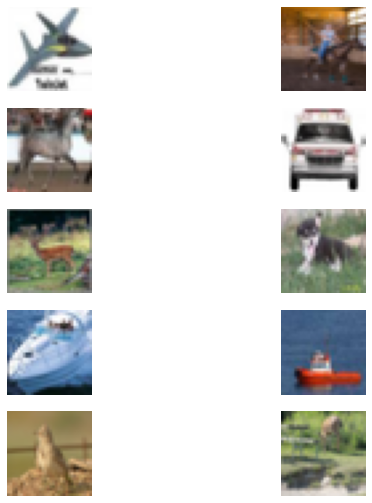

In [5]:
# show some random pics

show_n = 10
assert show_n % 2 == 0, f"{show_n} needs to be an even number"
np.random.seed(100)
show_indices = np.random.choice(x_train_img.shape[0], show_n, replace=False)
x_train_img_show = x_train_img[show_indices]

fig, axs = plt.subplots(show_n // 2, 2,figsize=(9,9))

for idx, img in enumerate(x_train_img_show):
    col_idx = 1 - int(idx % 2 == 0)
    ax = axs[idx // 2, col_idx]
    ax.imshow(img)
    ax.axis('off')

plt.show()

### Pre-process

In [29]:
x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

x_train = x_train_un / 255.
x_val = x_val_un / 255.
x_test = x_test_un / 255.

mean = np.mean(x_train, axis=0).reshape(1, x_train.shape[1])
std = np.std(x_train, axis=0).reshape(1, x_train.shape[1])

x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

In [7]:
print(np.mean(x_train, axis=0))
print(np.mean(x_train, axis=0).shape)
print(np.std(x_train, axis=0))
print(x_train.shape)

print(np.mean(x_val, axis=0))
print(np.std(x_val, axis=0))

print(np.mean(x_test, axis=0))
print(np.std(x_test, axis=0))

print(y_train.shape)
print(y_train.shape[0])

[ 1.14188659e-15 -6.18216589e-16  8.90314489e-15 ...  5.31555910e-15
  8.26625435e-15  1.97581895e-14]
(3072,)
[1. 1. 1. ... 1. 1. 1.]
(10000, 3072)
[-0.02151247 -0.01731957 -0.01718778 ... -0.00928345 -0.00494739
 -0.00583879]
[0.9972366  0.99489016 0.99599598 ... 0.99822343 0.98979069 0.99003225]
[-0.01997713 -0.01194233 -0.00644388 ... -0.01584402 -0.00696293
  0.00331293]
[0.99457784 0.98900477 0.98955298 ... 0.98649573 0.97809437 0.98249776]
(10000,)
10000


In [8]:
class SVMClassifier():
    def __init__(self,):
        pass
    
    def forward(self,):
        pass
        
    def backward(self,):
        pass
    
    def loss(self,):
        pass

### NN

In [9]:
class Optimizer():
    def __init__(self, lr):
        self.lr = lr
        
    def step(self, w, b, dw, db):
        w -= self.lr * dw
        b -= self.lr * db
        
        return w, b


class L2Regularizer():
    def __init__(self, reg_rate):
        self.reg_rate = reg_rate
    
    def loss(self, w):
        return self.reg_rate * np.sum(w * w)
    
    def grad(self, w):
        return self.reg_rate * 2 * w

In [10]:
class Classifier():
    def __init__(self, output_dim):
        self.output_dim = output_dim
    
    def accuracy(self, y_hat, y):
        """
        y.shape = (batch,)
        y_hat.shape = (batch,)
        """
        n = y.shape[0]
        return np.where(y_hat == y)[0].size / n

In [11]:
class SoftmaxClassifier(Classifier):
    def __init__(self, output_dim):
        super().__init__(output_dim)

    def forward(self, s):
        """
        s.shape = (batch, output_dim)
        sum_exp_s.shape = (batch, 1)
        p.shape = (batch, output_dim)
        """
        # numerical stability
        s = s - np.max(s, axis=1, keepdims=True)
        sum_exp_s = np.exp(s).sum(axis=1, keepdims=True)
        print(f"sum_exp_s.shape={sum_exp_s.shape}")
        p = np.exp(s) / sum_exp_s
        print(f"p.shape={p.shape}")
        assert s.shape[1] == self.output_dim
        assert p.shape[1] == self.output_dim
        return p
        
    def backward(self, p, y):
        """
        ds.shape = (batch, output_dim)
        """
        n = y.shape[0]
        ds = np.copy(p) #changed
        ds[np.arange(n), y] =- 1
        ds /= n
        print(f"ds.shape={ds.shape}")
        assert ds.shape[1] == self.output_dim
        return ds
    
    def loss(self, p, y):
        """
        l.shape = ()
        """
        n = y.shape[0]
        l = np.sum(-np.log(p[np.arange(n), y])) / n
        print(f"l={l}")
        return l
    
    def predict(self, p):
        """
        p.shape = (batch, output_dim)
        returns of shape = (batch,) , this is y_hat
        """
        assert p.shape[1] == self.output_dim
        return np.argmax(p, axis=1)

In [12]:
class Dense():
    def __init__(self, input_dim, output_dim, regularizer):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.init_params(input_dim, output_dim)
        self.cache = {}
        self.grads = {}
        self.regularizer = regularizer
    
    def init_params(self, input_dim, output_dim):
        """
        w.shape=(output_dim, input_dim)
        b.shape=(output_dim, 1)
        
        """
        np.random.seed(123)
        self.w = np.random.normal(loc=0, scale=0.01, size=(output_dim, input_dim))
        np.random.seed(123)
        self.b = np.random.normal(loc=0, scale=0.01, size=(output_dim, 1))
    
    def update_params(self, optimizer):
        """
        w.shape=(output_dim, input_dim)
        b.shape=(output_dim, 1)
        dw.shape=(output_dim, input_dim)
        db.shape=(output_dim, 1)
        """
        dw = self.grads["dw"]
        db = self.grads["db"]
        
        assert dw.shape == (self.output_dim, self.input_dim)
        assert db.shape == (self.output_dim, 1)
        
        self.w, self.b = optimizer.step(self.w, self.b, dw, db)
    
    def forward(self, x):
        """
        x.shape = (batch, input_dim)
        w.shape=(output_dim, input_dim)
        b.shape=(output_dim, 1)
        s.shape = (batch, output_dim)
        """
        print(x.shape)
        assert x.shape[1] == self.input_dim
        self.cache["x"] = x
        s = np.dot(x, self.w.T) + self.b.T
        assert s.shape[1] == self.output_dim
        
        l_reg = self.regularizer.loss(self.w)
        assert l_reg.shape == ()
        self.cache["l_reg"] = l_reg
        
        return s
        
    def backward(self, g):
        """
        x.shape = (batch, input_dim)
        g.shape = (batch, output_dim)
        dw.shape=(output_dim, input_dim)
        db.shape=(output_dim, 1)
        """
        x = self.cache["x"]
        assert x.shape[1] == self.input_dim
        
        dw = np.dot(g.T, x)
        db = np.sum(g, axis=0).reshape(-1,1)
        
        dw_reg = self.regularizer.grad(self.w)
        db_reg = self.regularizer.grad(self.b)
        
        dw += dw_reg
        db += db_reg
        
        assert dw.shape == (self.output_dim, self.input_dim)
        assert db.shape == (self.output_dim, 1)
        
        self.grads["dw"] = dw
        self.grads["db"] = db
        
        g = np.dot(g, self.w) #dims?
        assert g.shape[1] == self.input_dim
        
        return g
    
    def get_w(self):
        return self.w
    
    def get_b(self):
        return self.b
    
    def get_l_reg(self, ):
        print(f"l_reg: {self.cache['l_reg']}")
        return self.cache["l_reg"]
    
    def empty_cache(self,):
        self.cache = {}
        
    def empty_grads(self, ):
        self.grads = {}
        
    def __repr__(self,):
        w_shape = f"w.shape={self.w.shape}"
        b_shape = f"b.shape={self.b.shape}"
        repr_str = w_shape + "\n" + b_shape
        return repr_str
        

class ReLU():
    def __init__(self,):
        self.cache = {}
    
    def forward(self, s):
        a = np.maximum(0, s)
        self.cache["a"] = a
        return a
    
    def backward(self, g):
        a = self.cache["a"]
        g[a <= 0] = 0.
        return g
    
    def get_w(self):
        return None
        
    def get_b(self):
        return None
    
    def get_l_reg(self, ):
        return 0.0
    
    def update_params(self, optimizer):
        pass
        
    def empty_cache(self,):
        self.cache = {}

In [26]:
class NN():
    def __init__(self, input_dim, output_dim):
        
        regularizer = L2Regularizer(reg_rate=0.1)
        
        mid_dim = 512
        
        self.layers = [
            Dense(input_dim, output_dim, regularizer),
        ]
        
        self.classifier = SoftmaxClassifier(output_dim)
        
    def forward_pass(self, x, y):
        
        s = np.copy(x)
        
        l_reg = 0
        
        for layer in self.layers:
            s = layer.forward(s)
            l_reg += layer.get_l_reg()
        
        p = self.classifier.forward(s)
        y_hat = self.classifier.predict(p)
        l_data = self.classifier.loss(p, y)
        
        print(f"l_data: {l_data}")
        print(f"l_reg: {l_reg}")
        l = l_data + l_reg
        
        acc = self.classifier.accuracy(y_hat, y)
        
        return y_hat, p, l, acc
    
    def backward_pass(self, p, y):
        
        g = self.classifier.backward(p, y)
        
        for layer in list(reversed(self.layers)):
            g = layer.backward(g)
            
    def apply_grads(self, optimizer):
        for layer in self.layers:
            layer.update_params(optimizer)
            
    def step(self, x, y):
        y_hat, p, l, acc = self.forward_pass(x, y)
        self.backward_pass(p, y)
        return y_hat, p, l, acc
            
    def fit(self, x, y, x_val, y_val, optimizer, n_epochs):
        self.train_loss_history = []
        self.train_accuracy_history = []
        
        self.val_loss_history = []
        self.val_accuracy_history = []
        
        batch_size = 100
        
        for epoch in range(n_epochs):
            
            
            # Shuffle data
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x = x[indices]
            y = y[indices]
            
            n_batch = int(x.shape[0] / batch_size)

            for b in range(n_batch):
                x_batch = x[b*batch_size:(b+1)*batch_size]
                y_batch = y[b*batch_size:(b+1)*batch_size]
            
                _, _, _, _ = self.step(x_batch, y_batch)
                self.apply_grads(optimizer)
            
            y_hat, p, l, acc = self.step(x, y)
            self.train_loss_history.append(l)
            self.train_accuracy_history.append(acc)
            print("-"*10)
            print(f"e={epoch}, train: l={l}, acc={acc}")
            
            y_hat, p, l, acc = self.step(x_val, y_val)
            self.val_loss_history.append(l)
            self.val_accuracy_history.append(acc)
            print(f"e={epoch}, val: l={l}, acc={acc}")
            print("-"*10)
            
        plt.plot(self.train_loss_history)
        plt.plot(self.val_loss_history)
        
    def __repr__(self):
        repr_str = ""
        for idx, layer in enumerate(self.layers):
            repr_str += "layer-" + str(idx) + ": " + layer.__repr__() + "\n"
        return repr_str

In [27]:
nn = NN(input_dim=x_train.shape[1], output_dim=10)
#nn = NN(input_dim=4, output_dim=10)
print(nn)

lr = 0.0001
optimizer = Optimizer(lr)

layer-0: w.shape=(10, 3072)
b.shape=(10, 1)



(100, 3072)
l_reg: 0.30581070674000227
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.402471317350101
l_data: 2.402471317350101
l_reg: 0.30581070674000227
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3057944896831084
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.554335624436754
l_data: 2.554335624436754
l_reg: 0.3057944896831084
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3057745816217458
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.4153029778032935
l_data: 2.4153029778032935
l_reg: 0.3057745816217458
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30575810028590605
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.3728765411374964
l_data: 2.3728765411374964
l_reg: 0.30575810028590605
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3057427554985723
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.4423309837366185
l_data: 2.4423309837366185
l_reg: 0.3057427554985723
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3057254109266067
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.4119673057941573
l_data: 2.4119673057941573
l

l_reg: 0.30460753927984174
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.2545086010345314
l_data: 2.2545086010345314
l_reg: 0.30460753927984174
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3045950836317195
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.3396760321642622
l_data: 2.3396760321642622
l_reg: 0.3045950836317195
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30458041892461446
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.288854024919968
l_data: 2.288854024919968
l_reg: 0.30458041892461446
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3045669680499969
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.2642658957662234
l_data: 2.2642658957662234
l_reg: 0.3045669680499969
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3045539745396196
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1979832587649937
l_data: 2.1979832587649937
l_reg: 0.3045539745396196
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30454261070188204
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.240420225052726
l_data: 2.240420225052726
l_reg: 0.304

sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1695087275349243
l_data: 2.1695087275349243
l_reg: 0.303302309157494
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30329147546678437
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1966116230506314
l_data: 2.1966116230506314
l_reg: 0.30329147546678437
ds.shape=(100, 10)
(10000, 3072)
l_reg: 0.3032793268432189
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=2.1428151826778303
l_data: 2.1428151826778303
l_reg: 0.3032793268432189
ds.shape=(10000, 10)
----------
e=1, train: l=2.4460945095210493, acc=0.2156
(10000, 3072)
l_reg: 0.3032793268432189
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=2.1511844925761108
l_data: 2.1511844925761108
l_reg: 0.3032793268432189
ds.shape=(10000, 10)
e=1, val: l=2.45446381941933, acc=0.2115
----------
(100, 3072)
l_reg: 0.3032793268432189
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.145108720040635
l_data: 2.145108720040635
l_reg: 0.3032793268432189
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30326897807249226
sum_ex

l_reg: 0.30235297609306544
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.036517974999637
l_data: 2.036517974999637
l_reg: 0.30235297609306544
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30234511136228637
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1036596455367946
l_data: 2.1036596455367946
l_reg: 0.30234511136228637
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30233560757568445
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.171083467968967
l_data: 2.171083467968967
l_reg: 0.30233560757568445
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30232383067837576
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9420886964162478
l_data: 1.9420886964162478
l_reg: 0.30232383067837576
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3023180284754595
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.186115367841242
l_data: 2.186115367841242
l_reg: 0.3023180284754595
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30230587360028827
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0331277663966913
l_data: 2.0331277663966913
l_reg: 0.3

l_reg: 0.3014618481642062
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.056345992828728
l_data: 2.056345992828728
l_reg: 0.3014618481642062
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30145323854641837
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0524012283824438
l_data: 2.0524012283824438
l_reg: 0.30145323854641837
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.30144432303783475
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0381496139556736
l_data: 2.0381496139556736
l_reg: 0.30144432303783475
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3014359426861831
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1176978751439193
l_data: 2.1176978751439193
l_reg: 0.3014359426861831
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.301425585022934
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9649628778260453
l_data: 1.9649628778260453
l_reg: 0.301425585022934
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3014189892540876
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.2412325424175994
l_data: 2.2412325424175994
l_reg: 0.3014

(10000, 3072)
l_reg: 0.30048007240399466
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=2.0352606288262183
l_data: 2.0352606288262183
l_reg: 0.30048007240399466
ds.shape=(10000, 10)
----------
e=4, train: l=2.335740701230213, acc=0.2757
(10000, 3072)
l_reg: 0.30048007240399466
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=2.0547669744747004
l_data: 2.0547669744747004
l_reg: 0.30048007240399466
ds.shape=(10000, 10)
e=4, val: l=2.355247046878695, acc=0.2628
----------
(100, 3072)
l_reg: 0.30048007240399466
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1146619441415795
l_data: 2.1146619441415795
l_reg: 0.30048007240399466
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3004694708691131
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.027772856744181
l_data: 2.027772856744181
l_reg: 0.3004694708691131
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.3004609744645843
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9598304216633469
l_data: 1.9598304216633469
l_reg: 0.3004609744645843
ds.shape=(100, 10)
(1

sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.213896718792836
l_data: 2.213896718792836
l_reg: 0.2998777308930264
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2998648360131938
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9394948657357198
l_data: 1.9394948657357198
l_reg: 0.2998648360131938
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29985843632338377
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.953595037773143
l_data: 1.953595037773143
l_reg: 0.29985843632338377
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2998525734597672
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8564327929221904
l_data: 1.8564327929221904
l_reg: 0.2998525734597672
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29984848963737026
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0340266788178485
l_data: 2.0340266788178485
l_reg: 0.29984848963737026
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29983997338674
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9583453820293344
l_data: 1.9583453820293344
l_reg: 0.29983997338674
ds.shape=(100, 10

sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9377422014267074
l_data: 1.9377422014267074
l_reg: 0.29909784875755074
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2990920076538021
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0156580188189333
l_data: 2.0156580188189333
l_reg: 0.2990920076538021
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2990834291390515
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0027968005826273
l_data: 2.0027968005826273
l_reg: 0.2990834291390515
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29907593194449694
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0470683818149156
l_data: 2.0470683818149156
l_reg: 0.29907593194449694
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29906618908051386
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.001050386079569
l_data: 2.001050386079569
l_reg: 0.29906618908051386
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.299058265091433
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.097450040835565
l_data: 2.097450040835565
l_reg: 0.299058265091433
ds.shape=(100,

l_reg: 0.29815736622634
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.903873563929463
l_data: 1.903873563929463
l_reg: 0.29815736622634
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2981527814771709
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8729500942879305
l_data: 1.8729500942879305
l_reg: 0.2981527814771709
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2981491772276639
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0031727176092353
l_data: 2.0031727176092353
l_reg: 0.2981491772276639
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29814160002533713
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.072892362800875
l_data: 2.072892362800875
l_reg: 0.29814160002533713
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2981321926809017
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.960756183723232
l_data: 1.960756183723232
l_reg: 0.2981321926809017
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2981252661854436
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0349865811528205
l_data: 2.0349865811528205
l_reg: 0.298125266185

(10000, 3072)
l_reg: 0.29738485927161173
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9723162800604441
l_data: 1.9723162800604441
l_reg: 0.29738485927161173
ds.shape=(10000, 10)
----------
e=8, train: l=2.2697011393320556, acc=0.3073
(10000, 3072)
l_reg: 0.29738485927161173
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=2.002407845707255
l_data: 2.002407845707255
l_reg: 0.29738485927161173
ds.shape=(10000, 10)
e=8, val: l=2.299792704978867, acc=0.2912
----------
(100, 3072)
l_reg: 0.29738485927161173
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9360043695614813
l_data: 1.9360043695614813
l_reg: 0.29738485927161173
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2973781235659926
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.010891741851093
l_data: 2.010891741851093
l_reg: 0.2973781235659926
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2973694226810584
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.939194916864642
l_data: 1.939194916864642
l_reg: 0.2973694226810584
ds.shape=(100, 10)
(100,

(100, 3072)
l_reg: 0.2968389482512119
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9815660898559317
l_data: 1.9815660898559317
l_reg: 0.2968389482512119
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29683167600100874
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1211158074602174
l_data: 2.1211158074602174
l_reg: 0.29683167600100874
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29682150233339516
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.06748361909215
l_data: 2.06748361909215
l_reg: 0.29682150233339516
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2968117404425225
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.944717611802769
l_data: 1.944717611802769
l_reg: 0.2968117404425225
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2968056894265662
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.868361646858287
l_data: 1.868361646858287
l_reg: 0.2968056894265662
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29680207987884655
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9966263676355416
l_data: 1.9966263676355416
l_re

l=2.049938884316233
l_data: 2.049938884316233
l_reg: 0.2960799808467474
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2960702520120564
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9640363571474062
l_data: 1.9640363571474062
l_reg: 0.2960702520120564
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2960634487976338
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8836629833228822
l_data: 1.8836629833228822
l_reg: 0.2960634487976338
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29605891847454924
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.999883709585193
l_data: 1.999883709585193
l_reg: 0.29605891847454924
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29605269021333586
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0642795247194807
l_data: 2.0642795247194807
l_reg: 0.29605269021333586
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29604291336644784
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1364201824951112
l_data: 2.1364201824951112
l_reg: 0.29604291336644784
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29603223256243

(10000, 3072)
l_reg: 0.2953823083601834
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9461887749673814
l_data: 1.9461887749673814
l_reg: 0.2953823083601834
ds.shape=(10000, 10)
----------
e=11, train: l=2.241571083327565, acc=0.323
(10000, 3072)
l_reg: 0.2953823083601834
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.983207535918319
l_data: 1.983207535918319
l_reg: 0.2953823083601834
ds.shape=(10000, 10)
e=11, val: l=2.2785898442785024, acc=0.3053
----------
(100, 3072)
l_reg: 0.2953823083601834
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9437755935416843
l_data: 1.9437755935416843
l_reg: 0.2953823083601834
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2953764441820412
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.724764656324336
l_data: 1.724764656324336
l_reg: 0.2953764441820412
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2953761845714645
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8619619339531546
l_data: 1.8619619339531546
l_reg: 0.2953761845714645
ds.shape=(100, 10)
(100, 30

(100, 3072)
l_reg: 0.29495957566284164
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7678325245629847
l_data: 1.7678325245629847
l_reg: 0.29495957566284164
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2949582549987097
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8742662567278734
l_data: 1.8742662567278734
l_reg: 0.2949582549987097
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2949554985124195
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7814236761243325
l_data: 1.7814236761243325
l_reg: 0.2949554985124195
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29495502383235095
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9159221423916821
l_data: 1.9159221423916821
l_reg: 0.29495502383235095
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29494950259690084
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.002471803393993
l_data: 2.002471803393993
l_reg: 0.29494950259690084
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2949425968704919
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0004148073292467
l_data: 2.00041480732924

(100, 3072)
l_reg: 0.29417028532385786
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8416387248582238
l_data: 1.8416387248582238
l_reg: 0.29417028532385786
ds.shape=(100, 10)
(10000, 3072)
l_reg: 0.2941675118364035
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.93361696728576
l_data: 1.93361696728576
l_reg: 0.2941675118364035
ds.shape=(10000, 10)
----------
e=13, train: l=2.2277844791221635, acc=0.3305
(10000, 3072)
l_reg: 0.2941675118364035
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9747993003639637
l_data: 1.9747993003639637
l_reg: 0.2941675118364035
ds.shape=(10000, 10)
e=13, val: l=2.2689668122003672, acc=0.3103
----------
(100, 3072)
l_reg: 0.2941675118364035
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0294580168893113
l_data: 2.0294580168893113
l_reg: 0.2941675118364035
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29415910417136976
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.039553953493252
l_data: 2.039553953493252
l_reg: 0.29415910417136976
ds.shape=(100, 10)
(100

(10000, 3072)
l_reg: 0.29359452265148506
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9291221493464858
l_data: 1.9291221493464858
l_reg: 0.29359452265148506
ds.shape=(10000, 10)
----------
e=14, train: l=2.2227166719979707, acc=0.3338
(10000, 3072)
l_reg: 0.29359452265148506
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9723447303887427
l_data: 1.9723447303887427
l_reg: 0.29359452265148506
ds.shape=(10000, 10)
e=14, val: l=2.265939253040228, acc=0.3129
----------
(100, 3072)
l_reg: 0.29359452265148506
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9727532934194527
l_data: 1.9727532934194527
l_reg: 0.29359452265148506
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2935879847789859
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.011704004184571
l_data: 2.011704004184571
l_reg: 0.2935879847789859
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29358121744611476
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.845911230961287
l_data: 1.845911230961287
l_reg: 0.29358121744611476
ds.shape=(100, 10)

l_reg: 0.29321777471885246
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1089072286989166
l_data: 2.1089072286989166
l_reg: 0.29321777471885246
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29320809567193157
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8244802040272576
l_data: 1.8244802040272576
l_reg: 0.29320809567193157
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2932054612593222
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9883319765175802
l_data: 1.9883319765175802
l_reg: 0.2932054612593222
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2931982008166936
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9538537127893922
l_data: 1.9538537127893922
l_reg: 0.2931982008166936
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29319099110092106
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9184451849695474
l_data: 1.9184451849695474
l_reg: 0.29319099110092106
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2931855894018917
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.04108554343861
l_data: 2.04108554343861
l_reg: 0.29

l=1.7911590334414198
l_data: 1.7911590334414198
l_reg: 0.2925339399610393
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29253295836952087
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.060655315481897
l_data: 2.060655315481897
l_reg: 0.29253295836952087
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.292523980324715
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8599391215668277
l_data: 1.8599391215668277
l_reg: 0.292523980324715
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29251931281227644
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.865314778663961
l_data: 1.865314778663961
l_reg: 0.29251931281227644
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2925169236048339
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8442796789513611
l_data: 1.8442796789513611
l_reg: 0.2925169236048339
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29251483490013047
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8566113358678304
l_data: 1.8566113358678304
l_reg: 0.29251483490013047
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2925112012842086

(10000, 3072)
l_reg: 0.2919916261596546
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9172745889794929
l_data: 1.9172745889794929
l_reg: 0.2919916261596546
ds.shape=(10000, 10)
----------
e=17, train: l=2.2092662151391473, acc=0.3408
(10000, 3072)
l_reg: 0.2919916261596546
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9661041440352507
l_data: 1.9661041440352507
l_reg: 0.2919916261596546
ds.shape=(10000, 10)
e=17, val: l=2.258095770194905, acc=0.3197
----------
(100, 3072)
l_reg: 0.2919916261596546
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9332785295565702
l_data: 1.9332785295565702
l_reg: 0.2919916261596546
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2919868241300691
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1236398644916177
l_data: 2.1236398644916177
l_reg: 0.2919868241300691
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29197570033680614
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8865133658466489
l_data: 1.8865133658466489
l_reg: 0.29197570033680614
ds.shape=(100, 10)
(

sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8724937252822367
l_data: 1.8724937252822367
l_reg: 0.29160505449105806
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2916029018717023
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9491448615463234
l_data: 1.9491448615463234
l_reg: 0.2916029018717023
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29159793802753503
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9704828612368248
l_data: 1.9704828612368248
l_reg: 0.29159793802753503
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2915917500333439
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.058864580140639
l_data: 2.058864580140639
l_reg: 0.2915917500333439
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29158314506687855
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8755140416211267
l_data: 1.8755140416211267
l_reg: 0.29158314506687855
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2915782093209189
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8873298592562515
l_data: 1.8873298592562515
l_reg: 0.2915782093209189
ds.shape=(

l_reg: 0.29103162101214236
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.04729311580123
l_data: 2.04729311580123
l_reg: 0.29103162101214236
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2910234548072757
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9687618816509524
l_data: 1.9687618816509524
l_reg: 0.2910234548072757
ds.shape=(100, 10)
(10000, 3072)
l_reg: 0.29101714521271244
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.912104787522171
l_data: 1.912104787522171
l_reg: 0.29101714521271244
ds.shape=(10000, 10)
----------
e=19, train: l=2.2031219327348834, acc=0.3457
(10000, 3072)
l_reg: 0.29101714521271244
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9645047178799224
l_data: 1.9645047178799224
l_reg: 0.29101714521271244
ds.shape=(10000, 10)
e=19, val: l=2.255521863092635, acc=0.3246
----------
(100, 3072)
l_reg: 0.29101714521271244
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.6789407673425547
l_data: 1.6789407673425547
l_reg: 0.29101714521271244
ds.shape=(100, 10)
(100, 3072)
l

(10000, 3072)
l_reg: 0.29055559861442
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.909996834732361
l_data: 1.909996834732361
l_reg: 0.29055559861442
ds.shape=(10000, 10)
----------
e=20, train: l=2.200552433346781, acc=0.3474
(10000, 3072)
l_reg: 0.29055559861442
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9641212863367357
l_data: 1.9641212863367357
l_reg: 0.29055559861442
ds.shape=(10000, 10)
e=20, val: l=2.254676884951156, acc=0.3264
----------
(100, 3072)
l_reg: 0.29055559861442
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.05889106882913
l_data: 2.05889106882913
l_reg: 0.29055559861442
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29054765555216105
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8711157737062802
l_data: 1.8711157737062802
l_reg: 0.29054765555216105
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2905437297774882
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0552495689651424
l_data: 2.0552495689651424
l_reg: 0.2905437297774882
ds.shape=(100, 10)
(100, 3072)
l_reg: 0

(10000, 3072)
l_reg: 0.2901108002297176
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9080984232512728
l_data: 1.9080984232512728
l_reg: 0.2901108002297176
ds.shape=(10000, 10)
----------
e=21, train: l=2.1982092234809905, acc=0.3493
(10000, 3072)
l_reg: 0.2901108002297176
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9639416317757583
l_data: 1.9639416317757583
l_reg: 0.2901108002297176
ds.shape=(10000, 10)
e=21, val: l=2.254052432005476, acc=0.3282
----------
(100, 3072)
l_reg: 0.2901108002297176
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9853147525643116
l_data: 1.9853147525643116
l_reg: 0.2901108002297176
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.29010429179298153
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0735018960072074
l_data: 2.0735018960072074
l_reg: 0.29010429179298153
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2900941279316462
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.784378105655064
l_data: 1.784378105655064
l_reg: 0.2900941279316462
ds.shape=(100, 10)
(10

l_reg: 0.289765840894151
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9884537615502236
l_data: 1.9884537615502236
l_reg: 0.289765840894151
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.289757813383114
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9417726712671395
l_data: 1.9417726712671395
l_reg: 0.289757813383114
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2897518536596843
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.015270352406266
l_data: 2.015270352406266
l_reg: 0.2897518536596843
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28974412112426795
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9824793034569532
l_data: 1.9824793034569532
l_reg: 0.28974412112426795
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28973694064874594
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.962375770533097
l_data: 1.962375770533097
l_reg: 0.28973694064874594
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28973202042921514
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.96287507499168
l_data: 1.96287507499168
l_reg: 0.28973202042

l=1.8172569023235303
l_data: 1.8172569023235303
l_reg: 0.28928472538813504
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2892852678017849
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7335231997644465
l_data: 1.7335231997644465
l_reg: 0.2892852678017849
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28928908630599975
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9156064146642624
l_data: 1.9156064146642624
l_reg: 0.28928908630599975
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28928426081354797
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.778048411317423
l_data: 1.778048411317423
l_reg: 0.28928426081354797
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28928336563858
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.905850323405616
l_data: 1.905850323405616
l_reg: 0.28928336563858
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2892796795524566
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.949284710244942
l_data: 1.949284710244942
l_reg: 0.2892796795524566
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28927470432410446
sum

(10000, 3072)
l_reg: 0.28887446496227503
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.905278120050704
l_data: 1.905278120050704
l_reg: 0.28887446496227503
ds.shape=(10000, 10)
----------
e=24, train: l=2.1941525850129793, acc=0.3558
(10000, 3072)
l_reg: 0.28887446496227503
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9661289427523327
l_data: 1.9661289427523327
l_reg: 0.28887446496227503
ds.shape=(10000, 10)
e=24, val: l=2.2550034077146077, acc=0.3304
----------
(100, 3072)
l_reg: 0.28887446496227503
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.926511475390101
l_data: 1.926511475390101
l_reg: 0.28887446496227503
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2888701658997542
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9822422609606765
l_data: 1.9822422609606765
l_reg: 0.2888701658997542
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2888656603455761
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9943289412479788
l_data: 1.9943289412479788
l_reg: 0.2888656603455761
ds.shape=(100, 10)


sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8965651242541002
l_data: 1.8965651242541002
l_reg: 0.2886073373861073
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2886066750299951
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7897967734612004
l_data: 1.7897967734612004
l_reg: 0.2886066750299951
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28860680790875065
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0017519371403107
l_data: 2.0017519371403107
l_reg: 0.28860680790875065
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28860066880585533
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7321564552506628
l_data: 1.7321564552506628
l_reg: 0.28860066880585533
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2886003404630716
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9326734219005584
l_data: 1.9326734219005584
l_reg: 0.2886003404630716
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28859679980696734
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8246553819269982
l_data: 1.8246553819269982
l_reg: 0.28859679980696734
ds.shap

l=2.036293484600982
l_data: 2.036293484600982
l_reg: 0.288140312243153
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2881320087825412
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0119997266270837
l_data: 2.0119997266270837
l_reg: 0.2881320087825412
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2881270175897892
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8436638731789652
l_data: 1.8436638731789652
l_reg: 0.2881270175897892
ds.shape=(100, 10)
(10000, 3072)
l_reg: 0.2881241116634013
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9039296662387868
l_data: 1.9039296662387868
l_reg: 0.2881241116634013
ds.shape=(10000, 10)
----------
e=26, train: l=2.192053777902188, acc=0.3593
(10000, 3072)
l_reg: 0.2881241116634013
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9679076825202069
l_data: 1.9679076825202069
l_reg: 0.2881241116634013
ds.shape=(10000, 10)
e=26, val: l=2.2560317941836083, acc=0.3329
----------
(100, 3072)
l_reg: 0.2881241116634013
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.98

(10000, 3072)
l_reg: 0.28777175545412437
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9039249918136676
l_data: 1.9039249918136676
l_reg: 0.28777175545412437
ds.shape=(10000, 10)
----------
e=27, train: l=2.191696747267792, acc=0.3614
(10000, 3072)
l_reg: 0.28777175545412437
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9694304370247149
l_data: 1.9694304370247149
l_reg: 0.28777175545412437
ds.shape=(10000, 10)
e=27, val: l=2.2572021924788395, acc=0.3343
----------
(100, 3072)
l_reg: 0.28777175545412437
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9291166088683935
l_data: 1.9291166088683935
l_reg: 0.28777175545412437
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2877679148072118
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8355095812748459
l_data: 1.8355095812748459
l_reg: 0.2877679148072118
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2877662291293474
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9142095944791877
l_data: 1.9142095944791877
l_reg: 0.2877662291293474
ds.shape=(100, 1

l_reg: 0.2875336993378123
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9990950463406614
l_data: 1.9990950463406614
l_reg: 0.2875336993378123
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2875258937865401
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8452216623725384
l_data: 1.8452216623725384
l_reg: 0.2875258937865401
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28752288588565433
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1142922764403296
l_data: 2.1142922764403296
l_reg: 0.28752288588565433
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28751204898449856
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.2039479343457065
l_data: 2.2039479343457065
l_reg: 0.28751204898449856
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28750129283360654
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1619360110344705
l_data: 2.1619360110344705
l_reg: 0.28750129283360654
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2874919201314846
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9010979960808279
l_data: 1.9010979960808279
l_reg: 

l_reg: 0.2873421925635018
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9014116746335818
l_data: 1.9014116746335818
l_reg: 0.2873421925635018
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2873390420609644
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0099911095299907
l_data: 2.0099911095299907
l_reg: 0.2873390420609644
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28733339944356956
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0248012783332965
l_data: 2.0248012783332965
l_reg: 0.28733339944356956
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28732791322092666
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7799056083800258
l_data: 1.7799056083800258
l_reg: 0.28732791322092666
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28732765946702415
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9351723985879585
l_data: 1.9351723985879585
l_reg: 0.28732765946702415
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2873212062208802
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9761737777906572
l_data: 1.9761737777906572
l_reg: 

(10000, 3072)
l_reg: 0.2871110496211972
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9042593938665777
l_data: 1.9042593938665777
l_reg: 0.2871110496211972
ds.shape=(10000, 10)
----------
e=29, train: l=2.191370443487775, acc=0.3644
(10000, 3072)
l_reg: 0.2871110496211972
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9728697241494233
l_data: 1.9728697241494233
l_reg: 0.2871110496211972
ds.shape=(10000, 10)
e=29, val: l=2.2599807737706206, acc=0.3355
----------
(100, 3072)
l_reg: 0.2871110496211972
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8441568381363185
l_data: 1.8441568381363185
l_reg: 0.2871110496211972
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2871084520245632
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.75468310970675
l_data: 1.75468310970675
l_reg: 0.2871084520245632
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28711029226534956
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.829340991445121
l_data: 1.829340991445121
l_reg: 0.28711029226534956
ds.shape=(100, 10)
(100, 3

sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9537324716517153
l_data: 1.9537324716517153
l_reg: 0.2868531907113047
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.286846940739902
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8039159091061585
l_data: 1.8039159091061585
l_reg: 0.286846940739902
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2868482333110031
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9930384956062142
l_data: 1.9930384956062142
l_reg: 0.2868482333110031
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28684450440604875
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.910726096880125
l_data: 1.910726096880125
l_reg: 0.28684450440604875
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28684441815372785
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.6882860410035763
l_data: 1.6882860410035763
l_reg: 0.28684441815372785
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28684741313360684
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.760503173222228
l_data: 1.760503173222228
l_reg: 0.28684741313360684
ds.shape=(100

ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2865112223857964
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9324269726813106
l_data: 1.9324269726813106
l_reg: 0.2865112223857964
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28650650708359804
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8301043728607107
l_data: 1.8301043728607107
l_reg: 0.28650650708359804
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2865039578970387
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8737576637320092
l_data: 1.8737576637320092
l_reg: 0.2865039578970387
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.286501536560907
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8663525980283966
l_data: 1.8663525980283966
l_reg: 0.286501536560907
ds.shape=(100, 10)
(10000, 3072)
l_reg: 0.28650249756245566
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9052826715623785
l_data: 1.9052826715623785
l_reg: 0.28650249756245566
ds.shape=(10000, 10)
----------
e=31, train: l=2.191785169124834, acc=0.3678
(10000, 3072)
l_reg: 0.28650249756245566
sum_

(10000, 3072)
l_reg: 0.2862173287249023
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9055252060427073
l_data: 1.9055252060427073
l_reg: 0.2862173287249023
ds.shape=(10000, 10)
----------
e=32, train: l=2.1917425347676094, acc=0.3688
(10000, 3072)
l_reg: 0.2862173287249023
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9785186535546666
l_data: 1.9785186535546666
l_reg: 0.2862173287249023
ds.shape=(10000, 10)
e=32, val: l=2.2647359822795687, acc=0.338
----------
(100, 3072)
l_reg: 0.2862173287249023
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.982152063659428
l_data: 1.982152063659428
l_reg: 0.2862173287249023
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28621359810419295
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.115336989456796
l_data: 2.115336989456796
l_reg: 0.28621359810419295
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28620297602764466
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8088995619550219
l_data: 1.8088995619550219
l_reg: 0.28620297602764466
ds.shape=(100, 10)
(10

l_reg: 0.2860239007710734
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9396456023250508
l_data: 1.9396456023250508
l_reg: 0.2860239007710734
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28602216252338525
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0688796063881525
l_data: 2.0688796063881525
l_reg: 0.28602216252338525
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28601040221217033
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1598380139838045
l_data: 2.1598380139838045
l_reg: 0.28601040221217033
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.285999197926758
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.058204839657816
l_data: 2.058204839657816
l_reg: 0.285999197926758
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2859903091966453
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.5243041564040791
l_data: 1.5243041564040791
l_reg: 0.2859903091966453
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2860009223565219
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7074883313876756
l_data: 1.7074883313876756
l_reg: 0.2860

l_reg: 0.2857033408457953
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9439085955722013
l_data: 1.9439085955722013
l_reg: 0.2857033408457953
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2856995280629797
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9755303144363927
l_data: 1.9755303144363927
l_reg: 0.2856995280629797
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2856954241144771
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8081739732222497
l_data: 1.8081739732222497
l_reg: 0.2856954241144771
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2856950362685569
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8652648229301474
l_data: 1.8652648229301474
l_reg: 0.2856950362685569
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28569138409808037
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.017926854352469
l_data: 2.017926854352469
l_reg: 0.28569138409808037
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2856855951093059
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.654239478007664
l_data: 1.654239478007664
l_reg: 0.285685

(10000, 3072)
l_reg: 0.2854448986450188
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9082317387832688
l_data: 1.9082317387832688
l_reg: 0.2854448986450188
ds.shape=(10000, 10)
----------
e=35, train: l=2.1936766374282874, acc=0.3715
(10000, 3072)
l_reg: 0.2854448986450188
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9854596327180207
l_data: 1.9854596327180207
l_reg: 0.2854448986450188
ds.shape=(10000, 10)
e=35, val: l=2.2709045313630396, acc=0.3402
----------
(100, 3072)
l_reg: 0.2854448986450188
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8301858628142091
l_data: 1.8301858628142091
l_reg: 0.2854448986450188
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28544576776142955
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7384757502070673
l_data: 1.7384757502070673
l_reg: 0.28544576776142955
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28544841836766227
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.0974561475310285
l_data: 2.0974561475310285
l_reg: 0.28544841836766227
ds.shape=(100, 10

l_reg: 0.28529255445247603
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9041463419258964
l_data: 1.9041463419258964
l_reg: 0.28529255445247603
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2852892473213459
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8942855421958003
l_data: 1.8942855421958003
l_reg: 0.2852892473213459
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28528508576280437
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8776843354868817
l_data: 1.8776843354868817
l_reg: 0.28528508576280437
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28528523721217125
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9454516138459212
l_data: 1.9454516138459212
l_reg: 0.28528523721217125
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28528119985586
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1257776609126733
l_data: 2.1257776609126733
l_reg: 0.28528119985586
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2852752747198721
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.841510726732271
l_data: 1.841510726732271
l_reg: 0.2852

l_reg: 0.2850042861094499
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.1331027078794453
l_data: 2.1331027078794453
l_reg: 0.2850042861094499
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2849950066276241
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7484428668064091
l_data: 1.7484428668064091
l_reg: 0.2849950066276241
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28499708083930314
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.693698999900176
l_data: 1.693698999900176
l_reg: 0.28499708083930314
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2850006736997091
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8860603091514037
l_data: 1.8860603091514037
l_reg: 0.2850006736997091
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28500011090947835
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8298902005566335
l_data: 1.8298902005566335
l_reg: 0.28500011090947835
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2850032336830742
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.2888365063589116
l_data: 2.2888365063589116
l_reg: 0.28

(10000, 3072)
l_reg: 0.28478275330538455
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9117525453784212
l_data: 1.9117525453784212
l_reg: 0.28478275330538455
ds.shape=(10000, 10)
----------
e=38, train: l=2.1965352986838056, acc=0.3748
(10000, 3072)
l_reg: 0.28478275330538455
sum_exp_s.shape=(10000, 1)
p.shape=(10000, 10)
l=1.9930839128145614
l_data: 1.9930839128145614
l_reg: 0.28478275330538455
ds.shape=(10000, 10)
e=38, val: l=2.277866666119946, acc=0.3426
----------
(100, 3072)
l_reg: 0.28478275330538455
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.7920699933679045
l_data: 1.7920699933679045
l_reg: 0.28478275330538455
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2847821685895509
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.789020397339174
l_data: 1.789020397339174
l_reg: 0.2847821685895509
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2847826311934895
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9646573717974882
l_data: 1.9646573717974882
l_reg: 0.2847826311934895
ds.shape=(100, 10)

p.shape=(100, 10)
l=2.1683146266923314
l_data: 2.1683146266923314
l_reg: 0.2846617336107382
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.2846520163182909
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8172461780693783
l_data: 1.8172461780693783
l_reg: 0.2846520163182909
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28465601871685786
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9191431735121045
l_data: 1.9191431735121045
l_reg: 0.28465601871685786
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28465325155881444
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=2.018594879413064
l_data: 2.018594879413064
l_reg: 0.28465325155881444
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.28464960959698965
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.8260362454639127
l_data: 1.8260362454639127
l_reg: 0.28464960959698965
ds.shape=(100, 10)
(100, 3072)
l_reg: 0.284652916810335
sum_exp_s.shape=(100, 1)
p.shape=(100, 10)
l=1.9341961406047508
l_data: 1.9341961406047508
l_reg: 0.284652916810335
ds.shape=(100, 10)
(100, 3072)
l_reg

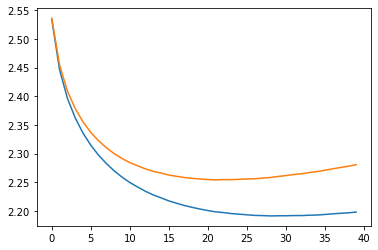

In [28]:
n_epochs = 40
#nn.fit(x=x_train, y=y_train, n_epochs=n_epochs)

nn.fit(x=x_train, y=y_train, x_val=x_val, y_val=y_val, n_epochs=n_epochs, optimizer=optimizer)

In [ ]:
x=x_train[121:123, 990:994]
y=y_train[121:123, ]

print(x.shape)
print(y.shape)

#_, _, l_original, _ = nn.step(x=x, y=y)


_, _, l, _ = nn.step(x=x, y=y)

h = 1e-4

for idx, layer in enumerate(nn.layers):
    
    grads = layer.grads
    
    dw = grads["dw"]
    db = grads["db"]
    
    dw_n = np.zeros(dw.shape)
    db_n = np.zeros(db.shape)
    
    w_copy = np.copy(layer.w)
    b_copy = np.copy(layer.b)

    
    for i in np.ndindex(layer.b.shape):
        print(i)
        
        
        print(layer.b)
        layer.b[i] = layer.b[i] + h
        
        _, _, l_pos_b, _ = nn.forward_pass(x=x, y=y)
        
        layer.b[i] = layer.b[i] - 2*h
        _, _, l_neg_b, _ = nn.forward_pass(x=x, y=y)
        
        layer.b[i] = np.copy(b_copy[i])
        print(layer.b)
        print("\n")
        
        db_n[i] = (l_pos_b - l_neg_b) / (2*h)
    
    print(db)
    print(db_n)
    
    #np.testing.assert_array_almost_equal(layer.grads["dw"], dw_n)
    #np.testing.assert_array_almost_equal(layer.grads["db"], db_n)
    v = np.abs(db - db_n)/(np.maximum(1e-8, np.abs(db) + np.abs(db_n)))
    print(v)
    print(np.average(v))
    assert np.mean(v) < 10e-6
    
    raise Exception

In [ ]:
class OneLayerNN():
    def __init__(self, input_dim, output_dim):
        """
        w.shape=(output_dim, input_dim)
        w.shape=(output_dim, 1)
        
        """
        self.w = np.random.normal(loc=0, scale=0.01, size=(output_dim, input_dim))
        self.b = np.zeros((output_dim, 1))
        self.lr = 0.01
    
    def dense_forward(self, x):
        return np.dot(x, self.w.T) + self.b.T
    
    def dense_backward(self, x, ds):
        dw = np.dot(ds.T, x)
        db = np.sum(ds, axis=0).reshape(-1,1)
        return dw, db
    
    def softmax_forward(self, s):
        s = s - np.max(s, axis=1, keepdims=True)
        sum_exp_s = np.exp(s).sum(axis=1, keepdims=True)
        print(f"sum_exp_s.shape={sum_exp_s.shape}")
        p = np.exp(s) / sum_exp_s
        print(f"p.shape={p.shape}")
        return p
        
    
    def softmax_backward(self, p, y):
        n = y.shape[0]
        ds = p
        ds[np.arange(n), y] =- 1
        ds /= n
        print(f"d_softmax.shape={ds.shape}")
        return ds
    
    
    def softmax_loss(self, p, y):
        n = y.shape[0]
        l = np.sum(-np.log(p[np.arange(n), y])) / n
        print(f"l={l}")
        return l
    
    def accuracy(self, y_hat, y):
        n = y.shape[0]
        return np.where(y_hat == y)[0].size / n
    
    def forward_pass(self, x, y):
        s = self.dense_forward(x)
        print(f"s.shape={s.shape}")
        p = self.softmax_forward(s)
        y_hat = np.argmax(p, axis=1)
        print(f"y_hat.shape={y_hat.shape}")
        return y_hat, p
    
    def backward_pass(self, x, p, y):
        d_softmax = self.softmax_backward(p, y)
        dw, db = self.dense_backward(x, d_softmax)
        print(f"dw.shape={dw.shape}")
        print(f"db.shape={db.shape}")
        return dw, db
    
    def update_params(self, lr, dw, db):
        self.w -= lr * dw
        self.b -= lr * db
    
    def step(self, x, y):
        y_hat, p = self.forward_pass(x, y)
        l = self.softmax_loss(p, y)
        dw, db = self.backward_pass(x, p, y)
        self.update_params(lr=self.lr, dw=dw, db=db)
        return l, y_hat
        
    def fit(self, x, y, n_epochs):
        
        loss_history = []
        
        for epoch in range(n_epochs):
            l, y_hat = self.step(x, y)
            loss_history.append(l)
            acc = self.accuracy(y_hat, y)
            print(f"e={epoch}, l={l}, acc={acc}")
            
        plt.plot(loss_history)
    
    def __repr__(self,):
        w_shape = f"w.shape={self.w.shape}"
        b_shape = f"b.shape={self.b.shape}"
        repr_str = w_shape + "\n" + b_shape
        return repr_str

In [ ]:
nn = OneLayerNN(input_dim=x_train.shape[1], output_dim=10)
print(nn)

In [ ]:
n_epochs = 40
nn.fit(x=x_train, y=y_train, n_epochs=n_epochs)